In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from tqdm import tqdm
from src.models import OldSpaceNet

In [2]:
train_steps = 50000

n_in = 2 # 2 position inputs 
n_out = 100 # no. of spatial representations
bs = 64 # batch size 

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = OldSpaceNet(n_in, n_out, device = device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

loss_history = []
progress = tqdm(range(train_steps))
for i in progress: # train loop
    r = torch.tensor(np.random.uniform(-1, 1, (bs, 2)), dtype= torch.float32, device=device)
    loss = model.train_step(x = r, y = r, optimizer = optimizer)

    if i % 10 == 0:
        loss_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")


/home/m/miniconda3/envs/ml/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
loss: 0.000402:  27%|██▋       | 13714/50000 [01:41<04:27, 135.42it/s]


KeyboardInterrupt: 

In [3]:
model.save("./saved_models/FF")

ValueError: x and y must have same first dimension, but have shapes (5000,) and (1372,)

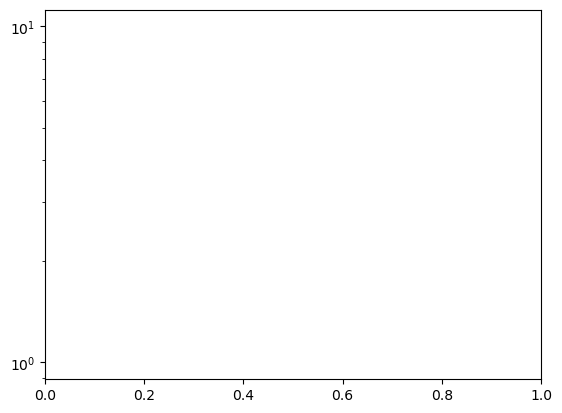

In [4]:
plt.semilogy(np.arange(0, train_steps, 10), loss_history, "-k", linewidth = 0.7)
plt.xlabel("Train Step")
plt.ylabel("Train Loss")

In [5]:
# evaluate on 32x32 grid
model.to('cpu')
n = 32
x = np.linspace(-1, 1, n)
y = x.copy()
xx, yy = np.meshgrid(x,y)
u = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis = -1), dtype= torch.float32)
p = model.spatial_representation(u).detach().numpy()
mask = np.mean(p, axis = 0) > 0

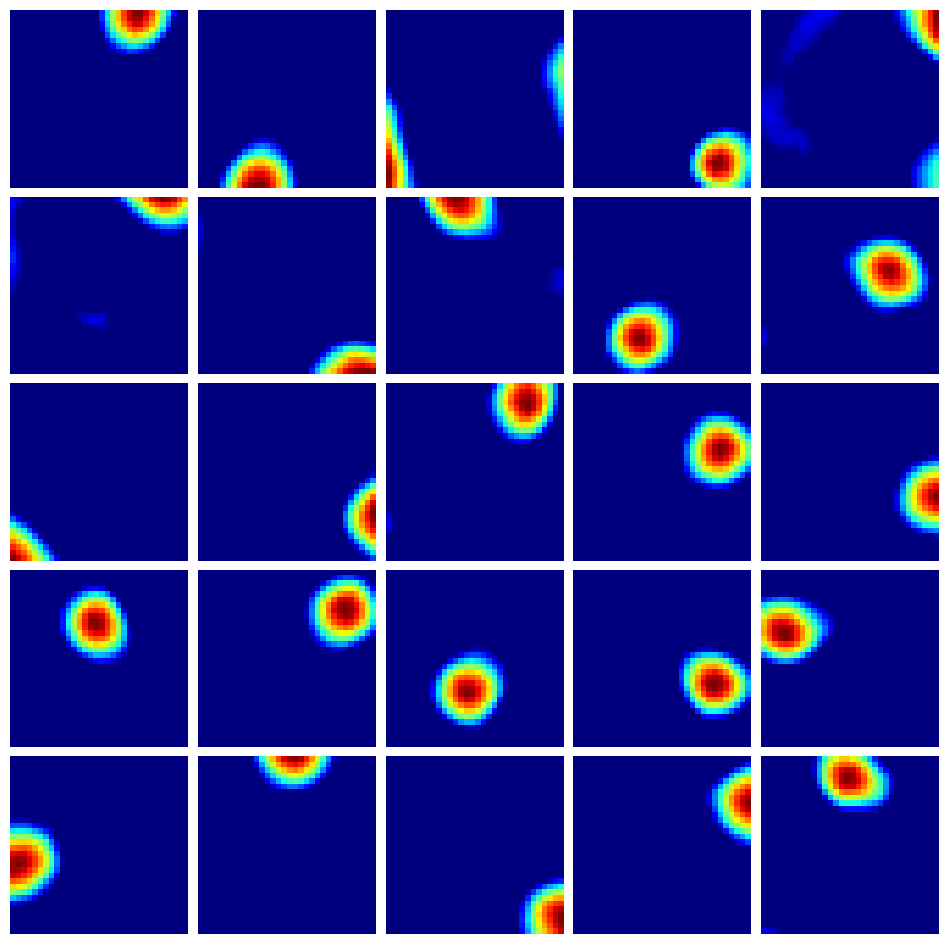

In [6]:
n_p = 5
fig, ax = plt.subplots(n_p, n_p, figsize =(12, 12))

for i, representation in enumerate(p.T[mask][:n_p**2]):

    row = i // n_p
    col = i % n_p
    ax[row, col].axis("off")

    representation = representation.reshape(n, n)

    ax[row, col].imshow(representation, cmap = "jet", interpolation = "none")

plt.subplots_adjust(wspace=0.05, hspace=0.05)

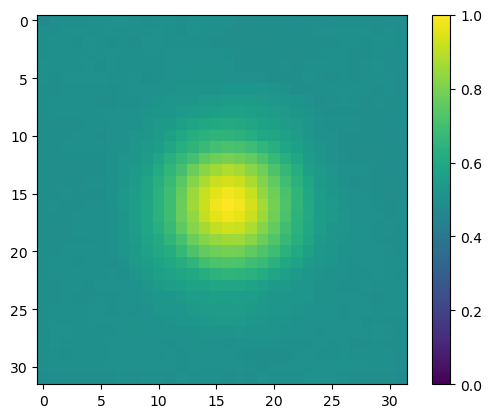

In [7]:
p0 = p[512+16]
sim = np.exp(-np.sum((p0[None] - p)**2, axis = -1))
plt.imshow(sim.reshape(32,32), interpolation = "None", vmin = 0)
plt.colorbar()